# MOF Recommender System: Analyzing data

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os

In [2]:
MIN_UNIQUE_ISOTHERMS = 7

<p style="text-align: center;">=====================================================================================================</p>

### The following notebook is split up into two sections: <b>[Data Manipulation](#data_manipulation)</b> and <b>[Data Visualization](#data_visualization)</b>

<a id='data_manipulation'></a>
# Data Manipulation

### Creating a Dictionary that converts InChIKey to gas and hashkey to mof

In [7]:
#Creates a dictionary of InChIKeys to gas names (and gas names to InChIKeys)
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

#Creates a dictionary for hashkeys to material names (and material names to hashkeys)
url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

### Taking out non experimental isotherms (excluding uncategorized isotherm)

In [8]:
url = "https://" + host + "/isodb/api/isotherms.json"
isotherm_data = json.loads(requests.get(url).content)

experimental_isotherms = []
print("Number of isotherms before cutting non experimental: {}".format(len(isotherm_data)))

for isotherm in reversed(isotherm_data):
    if isotherm['category'] == 'exp' or isotherm['category'] == '':
        experimental_isotherms.append(isotherm)
experimental_isotherms = np.array(experimental_isotherms)
print("Number of isotherms after cutting non experimental: {}".format(len(experimental_isotherms)))

Number of isotherms before cutting non experimental: 32553
Number of isotherms after cutting non experimental: 30401


### Grabs units

In [9]:
unit_filename = 'data/isotherm_file_units.csv'
units = []
filename_unit_dict = {}

# If `isotherm_file_units.csv` is not present, the following code will parse the database 
#  and grab the units of each isotherm file. The data will be written into a new `isotherm_file_units.csv` file
# WILL TAKE AROUND 3 HRS!
if os.path.isfile(unit_filename):
    print('File already exists.\nWill not download isotherm data from NIST database')
    isotherm_unit_data = pd.read_csv(unit_filename)
    units = isotherm_unit_data['units']
    for i in range(isotherm_unit_data.shape[0]):
        filename_unit_dict[isotherm_unit_data['isotherm_filename'][i]] = isotherm_unit_data['units'][i]
else:
    print('File does not exist.\nStarting a long process (roughly 3 hrs)')
    for isotherm in experimental_isotherms:
        filename = isotherm['filename']
        url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
        bibliography = json.loads(requests.get(url).content)
        units.append(bibliography['adsorptionUnits'])
        filename_unit_dict[filename] = bibliography['adsorptionUnits']
    with open(unit_filename, 'w') as outfile:
        outfile.write('isotherm_filename,units\n')
        for i, isotherm in enumerate(experimental_isotherms):
            outfile.write(isotherm['filename'] + ',' + units[i] + '\n')

File does not exist.
Starting a long process (roughly 3 hrs)


### This takes out materials with non viable units, binary/tertiary isotherms

In [6]:
viable_units = ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']
boolean_isotherm_array = [x_i in viable_units for x_i in units]

# Currently we will allow N2 and H2 isotherms at 77K, Ar isotherms at 87K, CO2 isotherms at [190K, 200K]
# and allow all isotherms around room temp, [293K, 303K].
n2_inchikey = 'IJGRMHOSHXDMSA-UHFFFAOYSA-N'
ar_inchikey = 'XKRFYHLGVUSROY-UHFFFAOYSA-N'
co2_inchikey = 'CURLTUGMZLYLDI-UHFFFAOYSA-N'
h2_inchikey = 'UFHFLCQGNIYNRP-UHFFFAOYSA-N'

# This dictionary is used to append a temperature to inchikeys. The purpose of that is so we can have 
#  a one-to-one mapping from gas-temp combination to column name, and from column name to gas-temp combination
temp_groups = {key: '_298K' for key in range(293,304)}
temp_groups[77] = '_77K'
temp_groups[87] = '_87K'
for key in range(190, 201):
    temp_groups[key] = '_195K'

print("Number of isotherms before cutting non viable units and gas mixtures: {}" .format(np.sum(boolean_isotherm_array)))

#Makes the boolean array false if the the units aren't viable or the gas is a mixture
for (i, isotherm) in enumerate(experimental_isotherms):
    inchikey = isotherm['adsorbates'][0]['InChIKey']
    if boolean_isotherm_array[i] and len(isotherm['adsorbates']) > 1:
        boolean_isotherm_array[i] = False
    # This is an explicit conditional to see if the isotherms is something we want to add (see comment at the top of the cell)
    if not ((isotherm['temperature'] <= 303 and isotherm['temperature'] >= 293)):# or
            #(inchikey in [n2_inchikey, h2_inchikey] and isotherm['temperature'] == 77) or
            #(inchikey == ar_inchikey and isotherm['temperature'] == 87) or
            #(inchikey == co2_inchikey and isotherm['temperature'] <= 200 and isotherm['temperature'] >= 190)):
        boolean_isotherm_array[i] = False
        
print("Number of Isotherms after cutting non viable units and gas mixtures: {}" .format(np.sum(boolean_isotherm_array)))

#The below two for loops take every experimental mof and gas and number them 
count = 0
material_to_row = {}
for isotherm in experimental_isotherms[boolean_isotherm_array]:
    if isotherm['adsorbent']['hashkey'] not in material_to_row:
        material_to_row[isotherm['adsorbent']['hashkey']] = count
        count += 1

row_to_material = dict(map(reversed, material_to_row.items())) #creates an inverted dictionary

count = 0
gas_temp_to_column = {}
for isotherm in experimental_isotherms[boolean_isotherm_array]:
    key = isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]
    if key not in gas_temp_to_column:
        gas_temp_to_column[key] = count
        count += 1
        
column_to_gas_temp = dict(map(reversed, gas_temp_to_column.items())) #creates an inverted dictionary

print("Number of gases/temps in the matrix: {}".format(len(gas_temp_to_column)))
print("Number of materials in the matrix: {}".format(len(material_to_row)))

Number of isotherms before cutting non viable units and gas mixtures: 26231


IndexError: list index out of range

### Lets combine/remove poorly-labelled materials

In [7]:
fixed_hashkeys = {key: key for key in key_to_material.keys()}

In [8]:
### Merging Co-MOF-74 (also known as CPO-27-Co) together ###
# Co-MOF-74(M) -> CPO-27-Co
fixed_hashkeys['NIST-MATDB-c57a094fb2e1b9fb1c5913c02c918de6'] = 'NIST-MATDB-1a1defab22ed24afae046ee6baf89096'
# Co-MOF-74(S) -> CPO-27-Co
fixed_hashkeys['NIST-MATDB-7bb7282a1b9e1de5a5fe3e9b36fbcf5a'] = 'NIST-MATDB-1a1defab22ed24afae046ee6baf89096'
# Co-DOBDC -> CPO-27-Co
fixed_hashkeys['NIST-MATDB-6e2be5d540f3133611c99ab5dd0db067'] = 'NIST-MATDB-1a1defab22ed24afae046ee6baf89096'
# Co2(dobdc) -> CPO-27-Co
fixed_hashkeys['NIST-MATDB-f540d0c8dc9b02024da8b1bde86fcd27'] = 'NIST-MATDB-1a1defab22ed24afae046ee6baf89096'

In [9]:
### Merging Mg-MOF-74 (also known as CPO-27-Mg) together ###
# CPO-27-Mg -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-57e293e89a8fbe91c2615546ac946518'] = 'NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9'
# CPO-27-Mg(100%) -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-175ee9d430f2213cfbc63d0329699f15'] = 'NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9'
# CPO-27-Mg-a -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-6f2f516bdc4e7127699c4a30bedfe0c3'] = 'NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9'
# CPO-27-Mg-b -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-70c2b94c27f7f7d4b838f89e2340ce8e'] = 'NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9'
# CPO-27-Mg-c -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-f5c54cdf45da93997fc911b2fa0af06c'] = 'NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9'
# Mg-MOF-74 (3) -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-ffef9fe8f87486bc0a607d2de561618d'] = 'NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9'
# Mg-MOF-74 (4) -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-df5a7d1b98bf856906a188166face5b4'] = 'NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9'
# MOF-74(Mg)-1st cycle -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-df5a7d1b98bf856906a188166face5b4'] = 'NIST-MATDB-7c2769672cb543e15f17087a66a23cb1'
# Mg-MOF-74(C) -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-20626755349323c194820984f3e0987b'] = 'NIST-MATDB-7c2769672cb543e15f17087a66a23cb1'
# Mg-MOF-74(C)-TEA -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-1c372977a54b1cbd3241f450681a73e1'] = 'NIST-MATDB-7c2769672cb543e15f17087a66a23cb1'
# Mg-MOF-74(S) -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-e505910010da31e2d0c1ca48f73e6141'] = 'NIST-MATDB-7c2769672cb543e15f17087a66a23cb1'
# Mg-DOBDC -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-c33e43f4637310daa19ea03a823bffc6'] = 'NIST-MATDB-7c2769672cb543e15f17087a66a23cb1'
# Mg2(dobdc) -> Mg-MOF-74
fixed_hashkeys['NIST-MATDB-f4b549a56c1a5caf008c436b7d0aaaea'] = 'NIST-MATDB-7c2769672cb543e15f17087a66a23cb1'

In [10]:
### Merging Ni-MOF-74 (also known as CPO-27-Ni) together ###
# Ni-MOF-74 (1) -> CPO-27-Ni
fixed_hashkeys['NIST-MATDB-78e8e8044f33dfb63d742cd181396dfc'] = 'NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28'
# Ni-MOF-74 (2) -> CPO-27-Ni
fixed_hashkeys['NIST-MATDB-2d9160505b3f649ff3c6a4c594f5fec1'] = 'NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28'
# MOF-74-Ni -> CPO-27-Ni
fixed_hashkeys['NIST-MATDB-775250b0154475da1a9521dd991a76d6'] = 'NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28'
# MOF-74Ni 70C -> CPO-27-Ni
fixed_hashkeys['NIST-MATDB-28648904f405f50f2bc5e3550b6e717a'] = 'NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28'
# Ni-DOBDC -> CPO-27-Ni
fixed_hashkeys['NIST-MATDB-9ab18a5aa1db0a6827d18e1707055261'] = 'NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28'
# Ni2(dobdc) -> CPO-27-Ni
fixed_hashkeys['NIST-MATDB-56a7e860822819db08b3fd9fc437f425'] = 'NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28'

In [11]:
### Merging Mn-MOF-74 (also known as CPO-27-Mn) together ###
# CPO-27-Mn -> Mn-MOF-74
fixed_hashkeys['NIST-MATDB-b959013d12b8df7d874e8bc19a3ad825'] = 'NIST-MATDB-f615a0462385c0cf6402e3408f388123'
# Mn-DOBDC -> Mn-MOF-74
fixed_hashkeys['NIST-MATDB-7517001fe32891a25f70bbfd9964bb45'] = 'NIST-MATDB-f615a0462385c0cf6402e3408f388123'
# Mn2(dobdc) -> Mn-MOF-74
fixed_hashkeys['NIST-MATDB-73a84356f3eb545dff5a90864019455a'] = 'NIST-MATDB-f615a0462385c0cf6402e3408f388123'

In [12]:
### Merging Zn-MOF-74 (also known as CPO-27-Zn or just MOF-74) together ###
# Zn-MOF-74(cycle 1) -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-37e0b260468f92bd2846629cb7a271fe'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# Zn-MOF-74(cycle 2) -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-68970216777fd2077aeabe1d8f5e04df'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# Zn-MOF-74(cycle 3) -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-307014997e274897af681c96d4b53c96'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# Zn-MOF-74(cycle 4) -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-d7c509e72d4a59cadd320724720c8497'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# Zn-MOF-74(cycle 5) -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-844eab1619bca6f71948e4d35957b9dc'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# CPO-27-Zn -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-0f4784144dbcf208e7eee52a5a18258f'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# MOF-74 -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-49b1e69854030020562c1a51b5d17de8'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# MOF-74 (DMF) -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-524bf0c00aa0a322fc87d21e20e1a054'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# MOF-74 (water) -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-3c4c41b68222f9e1a68bbb95e482de9a'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# Zn-DOBDC -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-722f158bdd6fb20e6204b3318ddffc08'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'
# Zn2(dobdc) -> Zn-MOF-74
fixed_hashkeys['NIST-MATDB-b7c532faf2e63ad3b792c61e5c687542'] = 'NIST-MATDB-71d6fc9e1d75f65e8a04544608290958'

In [13]:
### Merging Cu-BDC together ###
# Cu(BDC) (60mL DMF 100W Microwave) -> Cu-BDC
fixed_hashkeys['NIST-MATDB-4f4ea6d28daf156fe67bff9501a22f94'] = 'NIST-MATDB-babf81d2b7aa67c7a9223ef580779ebe'
# Cu(BDC) (60mL DMF 300W Microwave) -> Cu-BDC
fixed_hashkeys['NIST-MATDB-fb427c78453f425332952142af2a86ff'] = 'NIST-MATDB-babf81d2b7aa67c7a9223ef580779ebe'
# Cu(BDC) (87mL DMF 100W Microwave) -> Cu-BDC
fixed_hashkeys['NIST-MATDB-f69db56576571f7f96e90fb9d18f261b'] = 'NIST-MATDB-babf81d2b7aa67c7a9223ef580779ebe'
# Cu(BDC) (87mL DMF 300W Microwave) -> Cu-BDC
fixed_hashkeys['NIST-MATDB-582849fc3db6accef26f14f5e788581e'] = 'NIST-MATDB-babf81d2b7aa67c7a9223ef580779ebe'

In [14]:
### Merging Cu-BTC together ###
# Cu-BTC (diethylene glycol) -> CuBTC
fixed_hashkeys['NIST-MATDB-4f4ea6d28daf156fe67bff9501a22f94'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# Cu-BTC (ethylene glycol) -> CuBTC
fixed_hashkeys['NIST-MATDB-e6efc577f933134ec39fdeec5a8312b6'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# Cu-HKUST-1 -> CuBTC
fixed_hashkeys['NIST-MATDB-3b3e8d3742fee1969162f75b74614acc'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# CuBTC 100/100 -> CuBTC
fixed_hashkeys['NIST-MATDB-6c9dff8c3dd9dcf1c5f976f886222ed2'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# CuBTC 50/110 -> CuBTC
fixed_hashkeys['NIST-MATDB-90d81ef4b0b6588fd40875a146a3360b'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# CuBTC 75/110 -> CuBTC
fixed_hashkeys['NIST-MATDB-35f72795fd27dbc5296740e5e097af0f'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# CuBTC 75/140 -> CuBTC
fixed_hashkeys['NIST-MATDB-e25da32281d35800ad0c7161be3e6ddb'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# CuBTC 75/80 -> CuBTC
fixed_hashkeys['NIST-MATDB-6884b728736d834a811bbe4c60efad77'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# Cu2(BTC)3 -> CuBTC
fixed_hashkeys['NIST-MATDB-f5144c0dad75d197f715b89a81ff3ded'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# CuBTC(Cu) -> CuBTC
fixed_hashkeys['NIST-MATDB-083ee263712fa41d5ed2902450b5fbc5'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# CuBTC-MW -> CuBTC
fixed_hashkeys['NIST-MATDB-e829731c60f44b2f5695728a7a8a6311'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# HKUST-1 (0T) -> CuBTC
fixed_hashkeys['NIST-MATDB-6560a7ffb0aff1c661087cb74605669b'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
# HKUST-1 (1 pot) -> CuBTC
fixed_hashkeys['NIST-MATDB-b141fee78bde315b90c3b6e5eb86170a'] = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'

In [15]:
### Merging Cu-SDU-1 together ###
# Cu-SDU-1 (100 degrees C) -> Cu-SDU-1
fixed_hashkeys['NIST-MATDB-603aaadca73fbef155faffc549e937ff'] = 'NIST-MATDB-ed5049cd0f3b495ea431f5c70dd110be'
# Cu-SDU-1 (40 degrees C) -> Cu-SDU-1
fixed_hashkeys['NIST-MATDB-597ce8e24ddc4c43fcd7424520c8c58c'] = 'NIST-MATDB-ed5049cd0f3b495ea431f5c70dd110be'
# Cu-SDU-1 (80 degrees C) -> Cu-SDU-1
fixed_hashkeys['NIST-MATDB-f8fc01bcc21dc7a14b31c6fb5ab3c30b'] = 'NIST-MATDB-ed5049cd0f3b495ea431f5c70dd110be'

In [16]:
### Merging Fe-MOF-74 (also known as CPO-27-Fe) together ###
# CPO-27-Fe -> Fe-MOF-74
fixed_hashkeys['NIST-MATDB-cd4c05b741c6b7c1911b971187eb3859'] = 'NIST-MATDB-627250e1b90f307bafa15a3443ff8fa0'
# Fe2(dobdc) -> Fe-MOF-74
fixed_hashkeys['NIST-MATDB-1e93bd0672ca0c9d104d64b9ac6b00a2'] = 'NIST-MATDB-627250e1b90f307bafa15a3443ff8fa0'

In [17]:
### Merging IRMOF-1 (also known as MOF-5) together ###
# MOF-5 (1.5 hours activated) -> IRMOF-1
fixed_hashkeys['NIST-MATDB-1b711b4b15ba56839a674d11ab981e5b'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5 (Na2BDC 298) -> IRMOF-1
fixed_hashkeys['NIST-MATDB-07ec3f7785ead7d59d293afa508883b2'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5 (Na2BDC 373) -> IRMOF-1
fixed_hashkeys['NIST-MATDB-f805c6929f90235cc8f6cc73d0e1478d'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-.5h in humid air -> IRMOF-1
fixed_hashkeys['NIST-MATDB-a0c83fbf0f6134eb0ccef17ea18a1388'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-24h in humid air -> IRMOF-1
fixed_hashkeys['NIST-MATDB-fdcda7c9db17e468da0f28f9519808c3'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-2h in humid air -> IRMOF-1
fixed_hashkeys['NIST-MATDB-58781d83b17f1122d8b88dfd588ff4bc'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-48h in humid air -> IRMOF-1
fixed_hashkeys['NIST-MATDB-a3e8a660f897198e4e266891d6cece8a'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-40h -> IRMOF-1
fixed_hashkeys['NIST-MATDB-477cdab71f6f7d84c6a14630e6209e69'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-61% humidity -> IRMOF-1
fixed_hashkeys['NIST-MATDB-b47a3723414d2a0f5bb0db39183bc725'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-61% humidity-exposedtoair.5h -> IRMOF-1
fixed_hashkeys['NIST-MATDB-2ae62f6795b089253d11a2f33f268bb6'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-61% humidity-exposedtoair24h -> IRMOF-1
fixed_hashkeys['NIST-MATDB-c9505162f8871f9e1b5d9493eff116fa'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-61% humidity-exposedtoair2h -> IRMOF-1
fixed_hashkeys['NIST-MATDB-012062d91707a6839cf201220d6eb94b'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-61% humidity-exposedtoair48h -> IRMOF-1
fixed_hashkeys['NIST-MATDB-bb081c88ae500c1e18c9c8afbf605515'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-BPO -> IRMOF-1
fixed_hashkeys['NIST-MATDB-c756a86c44b988a15383fff3f2559e5b'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-BPO (cBPO = .04 M) -> IRMOF-1
fixed_hashkeys['NIST-MATDB-7e8cbec397be96acd8cc2af6586df65b'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'
# MOF-5-BPO (cBPO = .06 M) -> IRMOF-1
fixed_hashkeys['NIST-MATDB-aeec281795b82295ac0c267cf2530231'] = 'NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb'

In [18]:
### Merging Ni(bodc)(ted) together ###
# Ni-bodc-ted -> Ni(bodc)(ted)0.5
fixed_hashkeys['NIST-MATDB-2496ebae5844e7f787d87aa4d19f57f4'] = 'NIST-MATDB-69f363671c1af77d5e044616e37f0142'

In [19]:
### Merging Ni(bdc)(ted) together ###
# Ni(bdc)(ted)0.5 t=100 -> Ni(bdc)(ted)0.5
fixed_hashkeys['NIST-MATDB-a9ccb86911ddd4a4b4af5ee8b73bde32'] = 'NIST-MATDB-cb18d005dd9814be57be6b966232d228'
# Ni(bdc)(ted)0.5 t=15 -> Ni(bdc)(ted)0.5
fixed_hashkeys['NIST-MATDB-926d1905876e5a3799800f1975abb685'] = 'NIST-MATDB-cb18d005dd9814be57be6b966232d228'

In [20]:
### Merging PCN-14 together ###
# PCN-14(440) -> PCN-14
fixed_hashkeys['NIST-MATDB-6c84e04ad5307935cf302b7a56d921b2'] = 'NIST-MATDB-491f2d4553a5f70eb3e8a54f967be37f'
# PCN-14(450) -> PCN-14
fixed_hashkeys['NIST-MATDB-a314d0aec6a115c78f0edf9e205bda8d'] = 'NIST-MATDB-491f2d4553a5f70eb3e8a54f967be37f'
# PCN-14(500) -> PCN-14
fixed_hashkeys['NIST-MATDB-8247691bbe7dc87fc93ebe7aeed79000'] = 'NIST-MATDB-491f2d4553a5f70eb3e8a54f967be37f'
# PCN-14(550) -> PCN-14
fixed_hashkeys['NIST-MATDB-c555df2bf038a463c5a48ec95452691a'] = 'NIST-MATDB-491f2d4553a5f70eb3e8a54f967be37f'
# PCN-14(600) -> PCN-14
fixed_hashkeys['NIST-MATDB-a076fc44783e62338bddcfe21f88d236'] = 'NIST-MATDB-491f2d4553a5f70eb3e8a54f967be37f'

In [21]:
### Merging UiO-66 together ###
# UiO-66 (24h) -> UiO-66
fixed_hashkeys['NIST-MATDB-ee0b8f9147654f141126bf3e028b3c95'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'
# UiO-66 (2h) -> UiO-66
fixed_hashkeys['NIST-MATDB-afe548ab7dca88c70928c0a4ea0f21a2'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'
# UiO-66 (48h) -> UiO-66
fixed_hashkeys['NIST-MATDB-e902f58566fd0a2004a550a940444523'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'
# UiO-66 (4h) -> UiO-66
fixed_hashkeys['NIST-MATDB-d582b34a60e6cdca4d5631fd1c0e8a49'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'
# UiO-66 (72h) -> UiO-66
fixed_hashkeys['NIST-MATDB-5d0730ee5f95d8eacb43908544520b1e'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'
# UiO-66 (8h) -> UiO-66
fixed_hashkeys['NIST-MATDB-b4c3a99be7d58fe80ae481e35254aa49'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'
# UiO-66 (solvothermal) -> UiO-66
fixed_hashkeys['NIST-MATDB-776328b482a13e723523a8961ce9f838'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'
# UiO-66(Zr) -> UiO-66
fixed_hashkeys['NIST-MATDB-27ce47f74d79f611f6d3f9caa686697b'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'
# UiO-66(Zr) 100 Equ. FA -> UiO-66
fixed_hashkeys['NIST-MATDB-85d37896253b72c2a59809111397863f'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'
# UiO-66(Zr) 30 Equ. AA -> UiO-66
fixed_hashkeys['NIST-MATDB-e53176cc5034bf1da78dfc7e40235b5d'] = 'NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f'

In [22]:
### Merging UiO-66-NH2 together ###
# UiO-66-NH2(100) -> UiO-66-NH2
fixed_hashkeys['NIST-MATDB-edc1a45f13798a2193799eed9f8cdc84'] = 'NIST-MATDB-b425ac967ceb23a458c5e6f13f9dee6b'
# UiO-66-NH2(67) -> UiO-66-NH2
fixed_hashkeys['NIST-MATDB-a04881e0be0a2450c40fface8542bdb4'] = 'NIST-MATDB-b425ac967ceb23a458c5e6f13f9dee6b'
# UiO-66-NH2(33) -> UiO-66-NH2
fixed_hashkeys['NIST-MATDB-3828457a8446f2549a3e734d63fbccc2'] = 'NIST-MATDB-b425ac967ceb23a458c5e6f13f9dee6b'

In [23]:
### Merging UiO-66-(COOH)2 together ###
# UiO-66(Zr)-(COOH)2 -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-36203c6515663957b4115bad8e0ac2f7'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'
# UiO-66(Zr)-(COOH)2 (303K) -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-3684f463bca23b3e8fbf68c3a5d4537b'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'
# UiO-66(Zr)-(COOH)2 (323K) -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-fb724ebc336de9d29030c8b860c798ac'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'
# UiO-66(Zr)-(COOH)2 (343K) -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-4cf1b0768fd7d1493fa80fa803c53583'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'
# UiO-66(Zr)-(COOH)2 (348K) -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-4c152ffd93a16296c5c57d29cb322126'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'
# UiO-66(Zr)-(COOH)2 (373K) -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-6d2d1db79760dfda59f0e185d0c785fb'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'
# UiO-66(Zr)-(COOH)2 (383K) -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-bbc5554186146465369d3c26f52c2a14'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'
# UiO-66(Zr)-(COOH)2 (423K) -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-b8633e438eb4b3b1963008b5ffb3e34e'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'
# UiO-66(Zr)-(COOH)2 (463K) -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-6dbfc84a4c7fb76e4b1e17b510db65c9'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'
# UiO-66(Zr)-(COOH)2 (473K) -> UiO-66-(COOH)2
fixed_hashkeys['NIST-MATDB-184cb6ae0f79e0eb5a697b2cb877b943'] = 'NIST-MATDB-dfd5bcca69f38ac57ed86a59b463ab36'

In [24]:
### Merging SNU-9 together ###
# SNU-9 (10 cycles) -> SNU-9
fixed_hashkeys['NIST-MATDB-acec31f68d2378b9c043de6a16bfa6e8'] = 'NIST-MATDB-3d8168c3dd32cd01b769c05e9322fc7c'
# SNU-9 (100 cycles) -> SNU-9
fixed_hashkeys['NIST-MATDB-8048050ed8dd98a2d30a95f74ce629f4'] = 'NIST-MATDB-3d8168c3dd32cd01b769c05e9322fc7c'

In [25]:
### Merging ZIF-8 together ###
# ZIF-8 (BULK) -> ZIF-8
fixed_hashkeys['NIST-MATDB-0f026c529b8dbce43ab1a8f93d32d6cb'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (crystal = 0.060 micrometers) -> ZIF-8
fixed_hashkeys['NIST-MATDB-65586ffd03d5c6578352bca8e43eea08'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (crystal = 0.33 micrometers) -> ZIF-8
fixed_hashkeys['NIST-MATDB-4086472c344021a3a7bae6b0e0f9ee99'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (crystal = 0.47 micrometers) -> ZIF-8
fixed_hashkeys['NIST-MATDB-d0d4a00dca88fcd6a1daf124a6d0f3b0'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (crystal = 0.73 micrometers) -> ZIF-8
fixed_hashkeys['NIST-MATDB-806b047ed792834759122b96aeea277c'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (crystal = 1.2 micrometers) -> ZIF-8
fixed_hashkeys['NIST-MATDB-d02929ca9149f796309239c8c9e3197f'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (crystal = 2.1 micrometers) -> ZIF-8
fixed_hashkeys['NIST-MATDB-ee1f8becd5408b42cc699c8665523cad'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (crystal = 88 micrometers) -> ZIF-8
fixed_hashkeys['NIST-MATDB-ea6824163efda2c86a31ac1b19cd4578'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (Large Size) -> ZIF-8
fixed_hashkeys['NIST-MATDB-f108332cc894863591021dd5a9742893'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (Middle Size) -> ZIF-8
fixed_hashkeys['NIST-MATDB-30b86bde923dfc0ff11d0cfa351bfb35'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8 (Small Size) -> ZIF-8
fixed_hashkeys['NIST-MATDB-021539f42a454636d093f6f69c62d91f'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-0.025 WT% CTAB -> ZIF-8
fixed_hashkeys['NIST-MATDB-a6c829042a362d235c3c80cb4a5bb873'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-C_100_2d -> ZIF-8
fixed_hashkeys['NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-C_200_2d -> ZIF-8
fixed_hashkeys['NIST-MATDB-66d42068f1e5629859ba9fdf7c09f86e'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-C_250_2d -> ZIF-8
fixed_hashkeys['NIST-MATDB-98957dc3b3e5447085f30d255e6fb4ba'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-C_250_2d_V -> ZIF-8
fixed_hashkeys['NIST-MATDB-e7f5ee9ff70b311d1071cd0295607d40'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-M_100_7d -> ZIF-8
fixed_hashkeys['NIST-MATDB-9570b4a41337c5295be51a91badb6ca2'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-M_200_2d -> ZIF-8
fixed_hashkeys['NIST-MATDB-29a403743f98d55413472b87cd4b645b'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-M_250_2d -> ZIF-8
fixed_hashkeys['NIST-MATDB-852d85c1bfb55d0aa334c749ae6be48a'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-M_250_2d_V -> ZIF-8
fixed_hashkeys['NIST-MATDB-b7e060d2b9e62d8c0eb694a92ca0e9e4'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-W_100_7d -> ZIF-8
fixed_hashkeys['NIST-MATDB-64a0afb5b8f9e6b201da3a01486702e3'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-W_200_2d -> ZIF-8
fixed_hashkeys['NIST-MATDB-302129aea85cdef7ab891c682406feb2'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-W_250_2d -> ZIF-8
fixed_hashkeys['NIST-MATDB-02041b88ddcb320992ea67020eb825ec'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8-W_250_2d_V -> ZIF-8
fixed_hashkeys['NIST-MATDB-6c9e2dac4e4fa54b3a34a79e1341c320'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8ER -> ZIF-8
fixed_hashkeys['NIST-MATDB-23611bf363e26fdde5a07709f6c0d3e6'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8HP -> ZIF-8
fixed_hashkeys['NIST-MATDB-a9810d83ca1f83ad99326b1e0aba2326'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8HT -> ZIF-8
fixed_hashkeys['NIST-MATDB-f45852b78e947ca0e85d5fded942dbab'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8LT -> ZIF-8
fixed_hashkeys['NIST-MATDB-d57a879480bfaefde9066e70aad85325'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'
# ZIF-8LT-HT -> ZIF-8
fixed_hashkeys['NIST-MATDB-5873db2c75aeb7f53ac3e270802f6fad'] = 'NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b'

In [26]:
### Removing Pillared Layered Materials ###
# Pillared Layered Materials -> False
fixed_hashkeys['NIST-MATDB-bd4fe632a93717aa1dc57800af0c8760'] = False

In [27]:
### Merging MCM-41 together ###
# 2650 K MCM-41 -> MCM-41
fixed_hashkeys['NIST-MATDB-da0704e173358f5c41961bea4d952d44'] = 'NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd'
# 300 K MCM-41 -> MCM-41
fixed_hashkeys['NIST-MATDB-dd58bf9410fa0508b39b0fdf86f37060'] = 'NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd'
# MCM-41 d=2.8 nm -> MCM-41
fixed_hashkeys['NIST-MATDB-ecfc3f769a43c75934572a2c36393915'] = 'NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd'
# MCM-41 d=3.1 nm -> MCM-41
fixed_hashkeys['NIST-MATDB-50682113dafb4d0be695d8b439953374'] = 'NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd'
# MCM-41 1000C -> MCM-41
fixed_hashkeys['NIST-MATDB-380cab2263e5605b1dbae6be64a92586'] = 'NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd'
# MCM-41 500C -> MCM-41
fixed_hashkeys['NIST-MATDB-2662302a49635bf8fac39dbab11768af'] = 'NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd'
# MCM-41 700C -> MCM-41
fixed_hashkeys['NIST-MATDB-9950fb53a81dd1a1593c8e9b1775069d'] = 'NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd'
# MCM-41 900C -> MCM-41
fixed_hashkeys['NIST-MATDB-40c99f57d0167b1d4e222806e740527f'] = 'NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd'

In [28]:
### Merging Cu-MOF-74 together ###
# Cu-DOBDC (DREIDING Parameters-Universal Force Field + TraPPe Model) -> Cu-MOF-74
fixed_hashkeys['NIST-MATDB-6b401b60f11fa8853f5b1f5c4c3e6464'] = 'NIST-MATDB-2dcd78762c5032d1b5b3a93ef6f898b5'
# CPO-27-Cu -> Cu-MOF-74
fixed_hashkeys['NIST-MATDB-d94538fcbc59e241f4cb245f78b5a729'] = 'NIST-MATDB-2dcd78762c5032d1b5b3a93ef6f898b5'
# Cu2(dobdc) -> Cu-MOF-74
fixed_hashkeys['NIST-MATDB-fe08df81ae0b1ff9f883222e5c62a492'] = 'NIST-MATDB-2dcd78762c5032d1b5b3a93ef6f898b5'

In [29]:
for key in material_to_key:
    print('{:60s}\t\t\t{}'.format(key, material_to_key[key]))

                                                            			NIST-MATDB-8ae34e595b89def9186f316105e967e3
 [Cu3L2(mu3-OH)2(mu2-H2O)]·2DMA                             			NIST-MATDB-054bd15cb211d99e324d9adb3740eb52
((C4H11)2NH2)2Co3(hfbba)4                                   			NIST-MATDB-70f6c5cfd34cb7fca06b59d6350f5303
((Me2NH2)In(NH2BDC)2)                                       			NIST-MATDB-895aa514507d242d5062b7a2742cea92
(11,11) SWSiCNTA Rhombic                                    			NIST-MATDB-cf810d161ff8a621efc36928ee18c9f0
(11,11) SWSiCNTA Square                                     			NIST-MATDB-d992991f51feb0395addb5d2831dbc3e
(14,14) SWCNTA Rhombic                                      			NIST-MATDB-d02fb11a21f9b8c9c659b01402e459be
(14,14) SWCNTA Square                                       			NIST-MATDB-aa75343fb9fa51ddef2580eba909c194
(15,15) SWBNNT                                              			NIST-MATDB-6bac295ba935ab8f4d3fc8b32aafe75a
(15,15) SWCNT                        

### The following cell fills the Sparsity Matrix

In [30]:
AbstractString# Setting up a matrix of mofs and gases for available data and frequency of isotherms
material_gas_matrix = np.zeros((len(material_to_row),len(gas_temp_to_column)))
material_gas_frequency = np.zeros(material_gas_matrix.shape)
# We will also create a dictionary that takes in the material and gas, 
#  and points toward the filenames of the adsorption isotherms of the associated isotherms
material_gas_temp_to_filename = {}

# Now to fill in the matrix
for isotherm in experimental_isotherms[boolean_isotherm_array]:
    row_value = material_to_row[isotherm['adsorbent']['hashkey']]
    column_value = gas_temp_to_column[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]]
    corrected_hashkey = fixed_hashkeys[isotherm['adsorbent']['hashkey']]
    # corrected_hashkey == False only happens with materials that we have removed manually from the data set
    if corrected_hashkey == False:
        continue
    # The next two if-statements are used to initialize a dictionary/list for a gas/material combination if it hasn't been initialized
    if isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']] not in material_gas_temp_to_filename.keys():
        material_gas_temp_to_filename[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]] = {}
    if corrected_hashkey not in material_gas_temp_to_filename[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]].keys():
        material_gas_temp_to_filename[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]][corrected_hashkey] = []
    
    material_gas_temp_to_filename[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]][corrected_hashkey].append(isotherm['filename'])
    material_gas_matrix[row_value,column_value] = 1
    material_gas_frequency[row_value,column_value] += 1
    
with open('data/material_gas_to_filename.json', 'w') as outfile:
    json.dump(material_gas_temp_to_filename, outfile)

### Checking to see if all gas mixtures were successfully "taken out" of experimental_isotherm

In [31]:
for (i, isotherm) in enumerate(experimental_isotherms):
    if len(isotherm['adsorbates']) > 1:
        assert not boolean_isotherm_array[i]
    assert filename_unit_dict[isotherm['filename']] in viable_units or not boolean_isotherm_array[i]

### This takes a random value from the matrix to see if there is isotherm data on it and prints the isotherm data if present

In [32]:
count = 1
while True:
    gas_number = random.choice(range(len(gas_temp_to_column)))
    material_number = random.choice(range(len(material_to_row)))
    if material_gas_matrix[material_number,gas_number] == 1:
        for isotherm in experimental_isotherms:
            if isotherm['temperature'] not in temp_groups.keys():
                continue
            if isotherm['adsorbent']['hashkey'] == row_to_material[material_number] and isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']] == column_to_gas_temp[gas_number]:
                url = "https://adsorption.nist.gov/isodb/api/isotherm/" + isotherm['filename'] + ".json"
                bibliography = json.loads(requests.get(url).content)
                if bibliography['adsorptionUnits'] in viable_units and len(bibliography['adsorbates']) == 1 and isotherm['category'] in ['exp', '']:
                    print('Isotherm ' + str(count) + ' satisfies all conditions!')
                #pprint.pprint(bibliography) <-- if you want to check the actual isotherm file
                count += 1
        break

Isotherm 2 satisfies all conditions!


### Another Check to see if the matrix is correct

In [33]:
#This just tests to see if the matrix is correct, you can see the amount of gases each isotherm has and compare it to the matrix
#material_code[experimental_isotherm[12]['adsorbent']['hashkey']] correspnds with the first term in the matrix 'CuBTC'
#Code should give 53 different gases that 'CuBTC' has been tested with because that is the number that the number of ones in the sparsity matrix

CuBTC_hashkey = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
test_array=[]
for isotherm in experimental_isotherms[boolean_isotherm_array]:
    if isotherm['adsorbent']['hashkey'] == CuBTC_hashkey:
        test_array.append(key_to_gas[isotherm['adsorbates'][0]['InChIKey']])

print('The gases that are tested with CuBTC:') 
pprint.pprint(set(test_array))
print('Number of gases in the list: {}'.format(len(set(test_array))))
print('Number of gases in the first row of the matrix that corresponds with CuBTC: {}'.format(np.sum(material_gas_matrix[0,:])))

The gases that are tested with CuBTC:
{'2-Methylbutane',
 'Acetone',
 'Acetylene',
 'Ammonia',
 'Argon',
 'Benzene',
 'Carbon Dioxide',
 'Carbon Tetrachloride',
 'Carbon Tetrafluoride',
 'Carbon monoxide',
 'Cyclopentane',
 'Dichloromethane',
 'Ethane',
 'Ethanol',
 'Ethene',
 'Hydrogen',
 'Isobutane',
 'Isobutene',
 'Methane',
 'Methanol',
 'N-Butane',
 'N-Hexane',
 'N-Pentane',
 'N-propane',
 'Nitric oxide',
 'Nitrogen',
 'Oxygen',
 'Propene',
 'Sulfur dioxide',
 'Thiophene',
 'Trichloromethane',
 'Water',
 'Xenon'}
Number of gases in the list: 33
Number of gases in the first row of the matrix that corresponds with CuBTC: 16.0


### This takes out rows and columns that have too little data

In [34]:
def prune_matrix(min_data_points, verbose=True):
    keep_row = np.ones(len(material_to_row), dtype=bool)
    keep_column = np.ones(len(gas_temp_to_column), dtype=bool)
    nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
    gases_cut = 0
    materials_cut = 0
    count = 0

    while True:
        for i_row in range(len(material_to_row)):
            if np.sum(material_gas_matrix[i_row, keep_column]) < min_data_points:
                keep_row[i_row] = False

        for i_column in range(len(gas_temp_to_column)):
            if np.sum(material_gas_matrix[keep_row, i_column]) < min_data_points:
                keep_column[i_column] = False

        if nb_kept_rows_and_columns == (np.sum(keep_row) + np.sum(keep_column)):
            break

        nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
        count += 1

    materials_cut = np.sum(~keep_row)
    gases_cut = np.sum(~keep_column)

    if verbose:
        print("Number of materials cut: {}" .format(materials_cut))
        print("Number of gases cut: {}" .format(gases_cut))
        print('The remaining dimensions of the matrix are {} by {}'.format(len(material_to_row)-materials_cut,len(gas_temp_to_column)-gases_cut))
        print('The number of iterations of sparsing the matrix: {}'.format(count))
    
    return keep_row, keep_column

keep_row, keep_column = prune_matrix(MIN_UNIQUE_ISOTHERMS)

Number of materials cut: 2456
Number of gases cut: 104
The remaining dimensions of the matrix are 34 by 23
The number of iterations of sparsing the matrix: 2


<a id='data_visualization'></a>
# Data Visualization

In [35]:
def sort_matrix_by_freq(material_gas_matrix):
    row_sum = np.sum(material_gas_matrix, axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(material_gas_matrix[new_row_order, :], axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return material_gas_matrix[new_row_order, :][:, new_col_order]

### Analyzing the categories of the isotherms

The amount of uncategorized isotherms is 23068
The amount of epxerimental isotherms is 7332
The amount of modelled isotherms is 515
The amount of quantum isotherms is 118
The amount of simulated isotherms is 1519


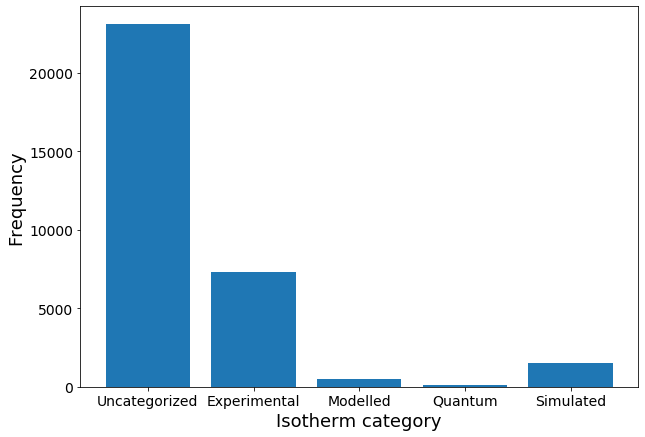

In [36]:
isotherm_category = []
for isotherm in isotherm_data:
    isotherm_category.append(isotherm['category'])

n_uncategorized = isotherm_category.count('')
n_experimental = isotherm_category.count('exp')
n_mod = isotherm_category.count('mod')
n_qua = isotherm_category.count('qua')
n_simulated = isotherm_category.count('sim')

print('The amount of uncategorized isotherms is {}'.format(n_uncategorized))
print('The amount of epxerimental isotherms is {}'.format(n_experimental))
print('The amount of modelled isotherms is {}'.format(n_mod))
print('The amount of quantum isotherms is {}'.format(n_qua))
print('The amount of simulated isotherms is {}'.format(n_simulated))


category_labels = ("Uncategorized", "Experimental", "Modelled", "Quantum", "Simulated")
y_pos = np.arange(len(category_labels))
bar_height = [n_uncategorized, n_experimental, n_mod, n_qua, n_simulated]

fig = plt.figure(figsize = (10,7))
ax = plt.gca()
ax.bar(y_pos, bar_height, align='center', alpha=1)
plt.xticks(y_pos, category_labels)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Isotherm category', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)



plt.show()

### Analyzing the temperature ranges in the dataset

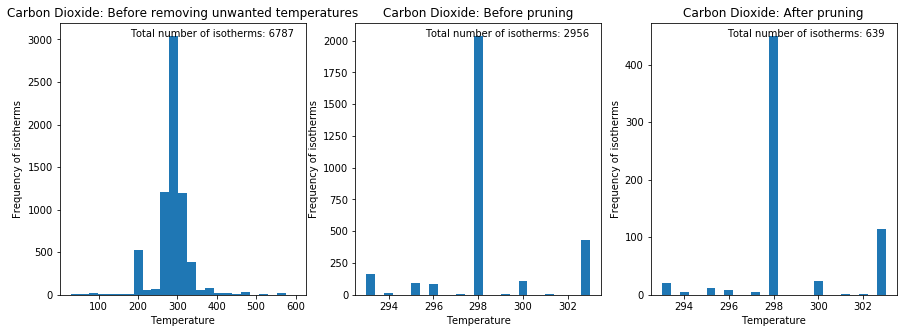

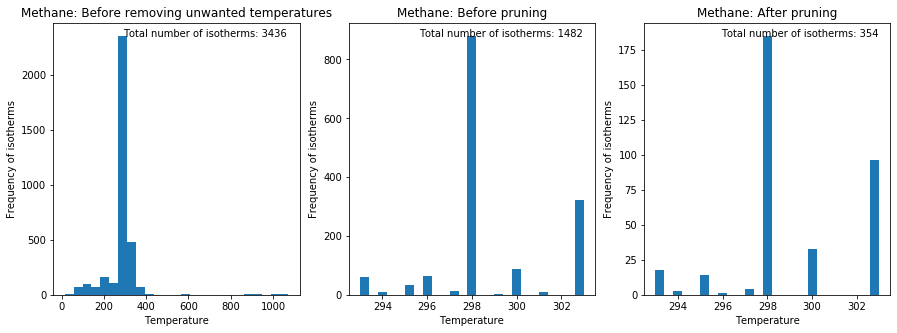

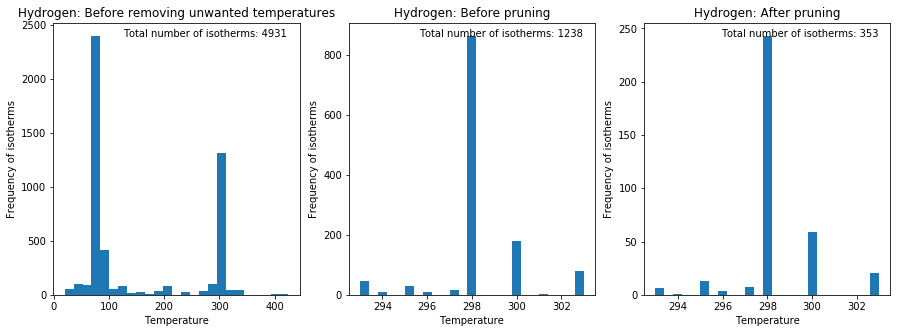

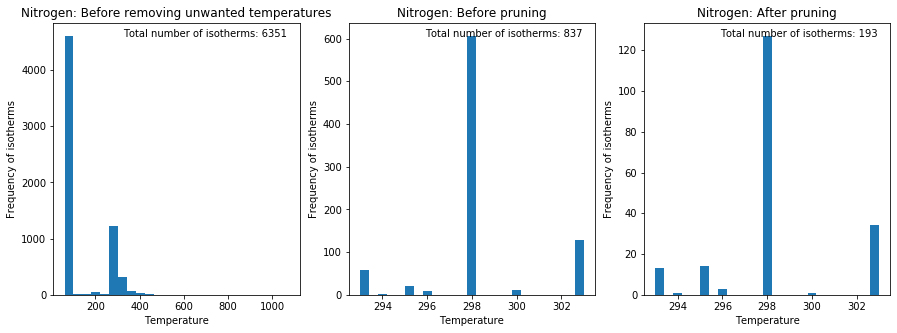

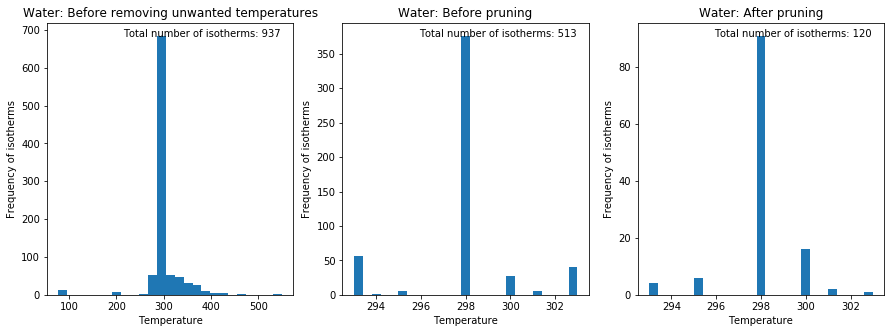

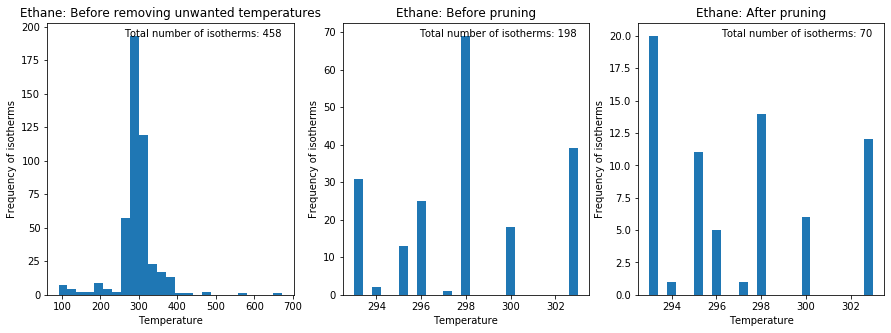

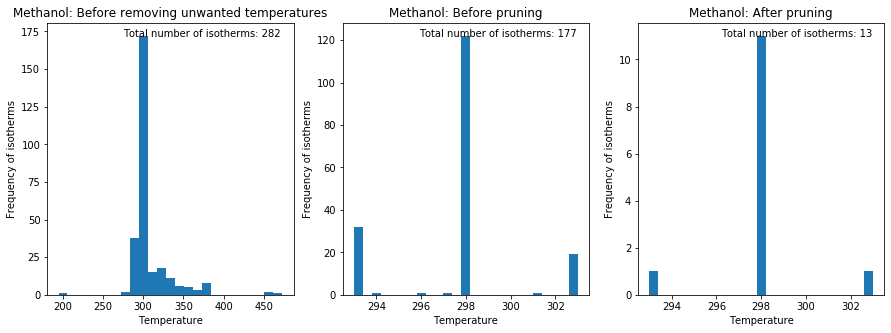

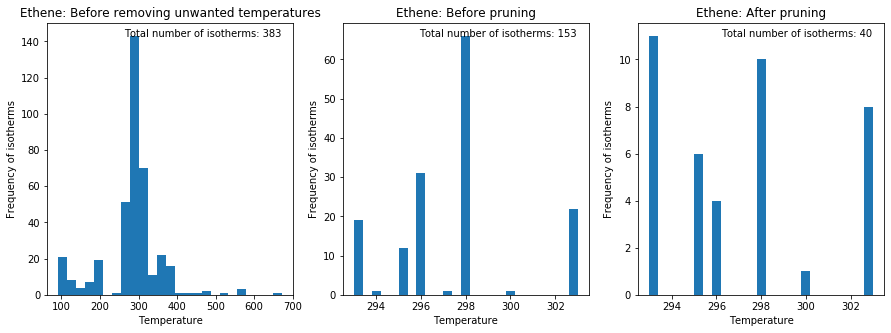

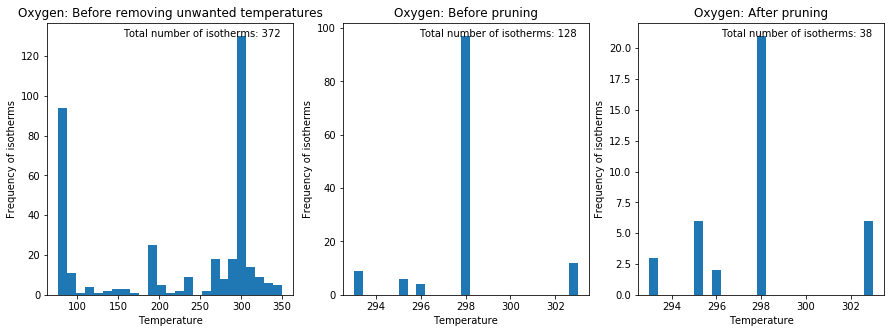

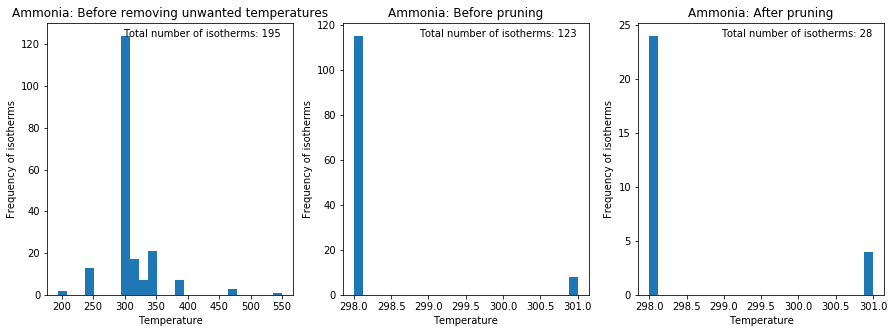

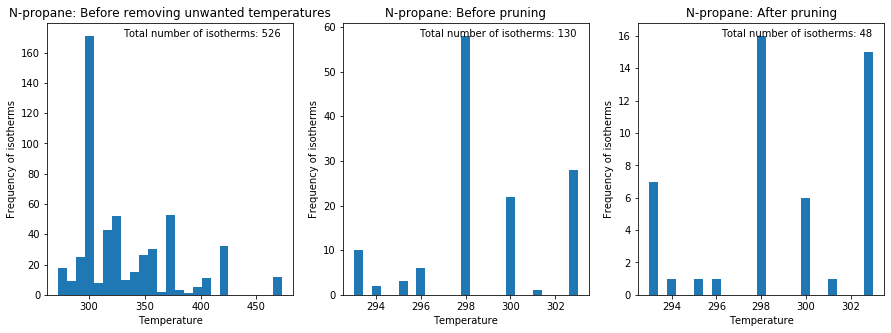

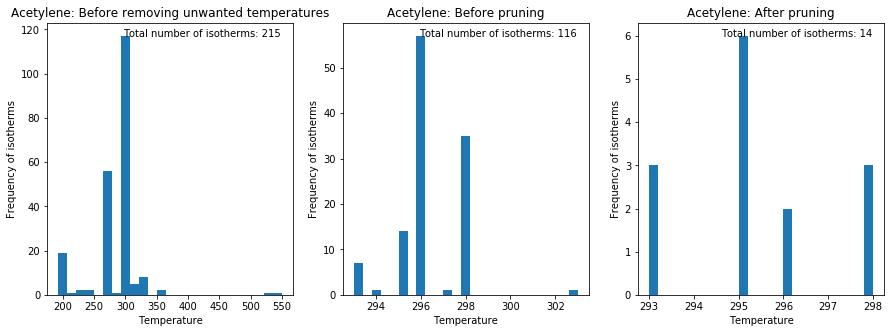

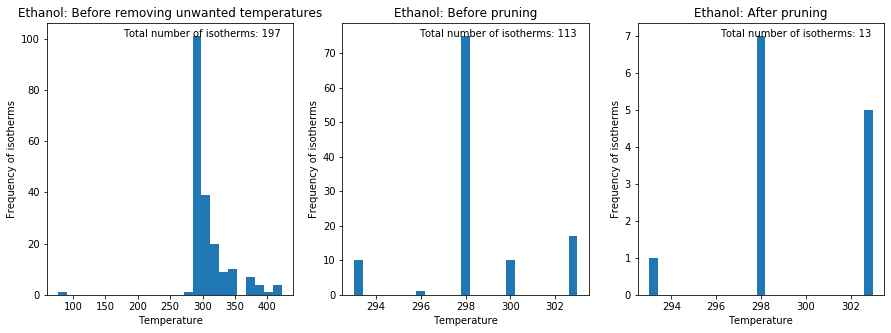

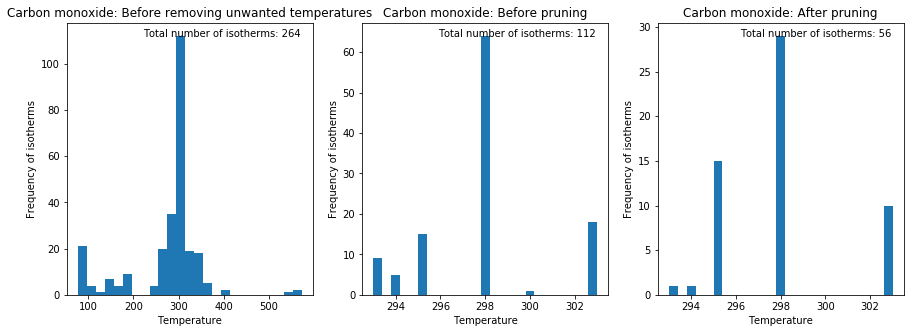

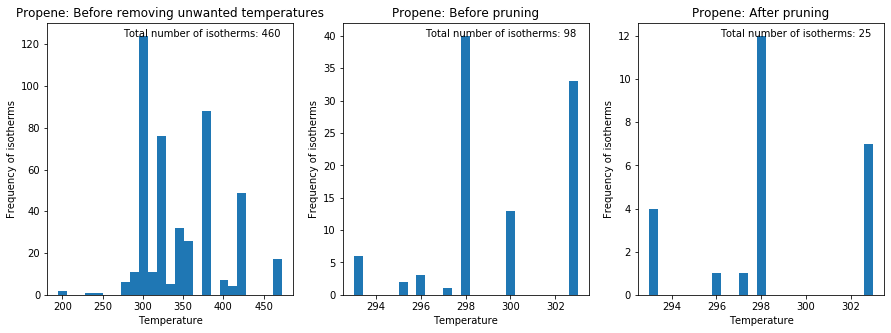

In [37]:
def inspect_temp_of_gas_isotherms(gas_name, min_data_points_for_pruning):
    assert gas_name in gas_to_key.keys()
    inchikey = gas_to_key[gas_name]
    
    temp_before_before = []
    temp_before = []
    temp_after = []
    for isotherm in np.array(experimental_isotherms):
        if isotherm['adsorbates'][0]['InChIKey'] == inchikey and len(isotherm['adsorbates']) < 2:
            temp_before_before.append(isotherm['temperature'])
    
    for isotherm in np.array(experimental_isotherms)[boolean_isotherm_array]:
        if isotherm['adsorbates'][0]['InChIKey'] == inchikey and len(isotherm['adsorbates']) < 2:
            temp_before.append(isotherm['temperature'])
    
    keep_row, keep_column = prune_matrix(min_data_points_for_pruning, False)
    for isotherm in np.array(experimental_isotherms)[boolean_isotherm_array]:
        i_col = gas_temp_to_column[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]]
        i_row = material_to_row[isotherm['adsorbent']['hashkey']]
        if keep_row[i_row] and keep_column[i_col] and isotherm['adsorbates'][0]['InChIKey'] == inchikey and len(isotherm['adsorbates']) < 2:
            temp_after.append(isotherm['temperature'])

    def create_subplot(ax, temp, title_label):
        ax.hist(temp, bins=25)
        ax.set_xlabel('Temperature')
        ax.set_ylabel('Frequency of isotherms')
        ax.set_title(title_label)
        ax.text(0.95, 0.95, 'Total number of isotherms: {}'.format(len(temp)), 
            horizontalalignment='right', transform=ax.transAxes)
        
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    create_subplot(axs[0], temp_before_before, gas_name + ': Before removing unwanted temperatures')
    create_subplot(axs[1], temp_before, gas_name + ': Before pruning')
    create_subplot(axs[2], temp_after, gas_name + ': After pruning')
    plt.show()
    
sums = np.sum(material_gas_frequency, axis=0)
old_order = np.arange(len(sums))

new_order = sorted(old_order, key=lambda x: sums[x], reverse=True)
most_common_gases = [key_to_gas[column_to_gas_temp[i].split('_')[0]] for i in new_order]
for gas in most_common_gases[:15]:
    inspect_temp_of_gas_isotherms(gas, MIN_UNIQUE_ISOTHERMS)

## Plotting the sparsed matrix and the original matrix side by side

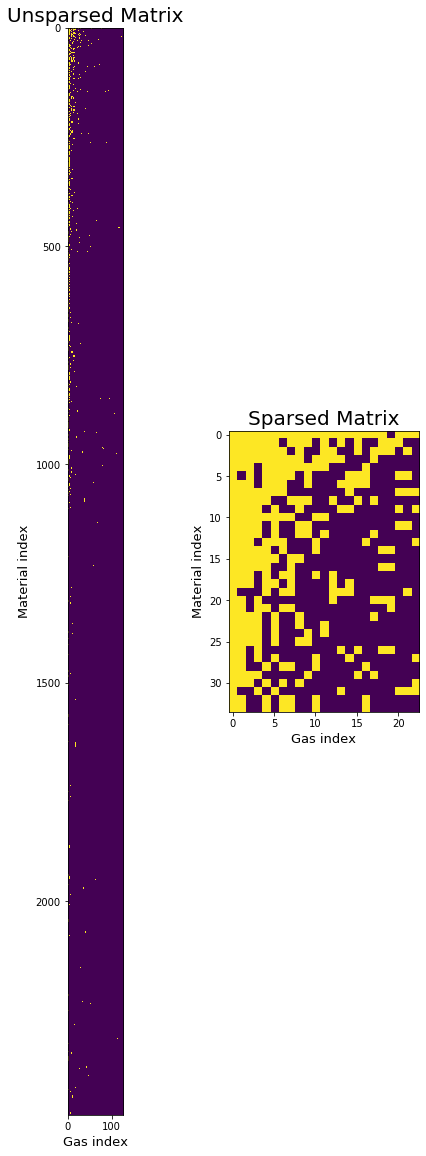

In [38]:
def plot_sparsity(min_data_points):
    
    keep_row, keep_column = prune_matrix(min_data_points, False)
    fig = plt.figure(figsize = (7.5,20))

    #subplot for the unsparsed matrix
    sorted_matrix = sort_matrix_by_freq(material_gas_matrix) 
    ax = plt.subplot(121)
    #plt.spy(sorted_matrix, aspect='auto', markersize=3.5)
    plt.imshow(sorted_matrix)
    plt.title('Unsparsed Matrix',fontsize = 20)
    plt.xlabel('Gas index',fontsize = 13)
    plt.ylabel('Material index',fontsize = 13)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')


    #subplot the sparsed matrix 
    sorted_sparsed_matrix = sort_matrix_by_freq(np.copy(material_gas_matrix[keep_row, :][:, keep_column]))
    ax = plt.subplot(122)
    #plt.spy(sorted_sparsed_matrix, aspect='auto', markersize=2, marker='s')
    plt.imshow(sorted_sparsed_matrix)
    plt.title('Sparsed Matrix',fontsize = 20)
    plt.xlabel('Gas index',fontsize = 13)
    plt.ylabel('Material index',fontsize = 13)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')

    plt.show()

plot_sparsity(MIN_UNIQUE_ISOTHERMS)


# Plotting the frequency of isotherms per gas/MOF

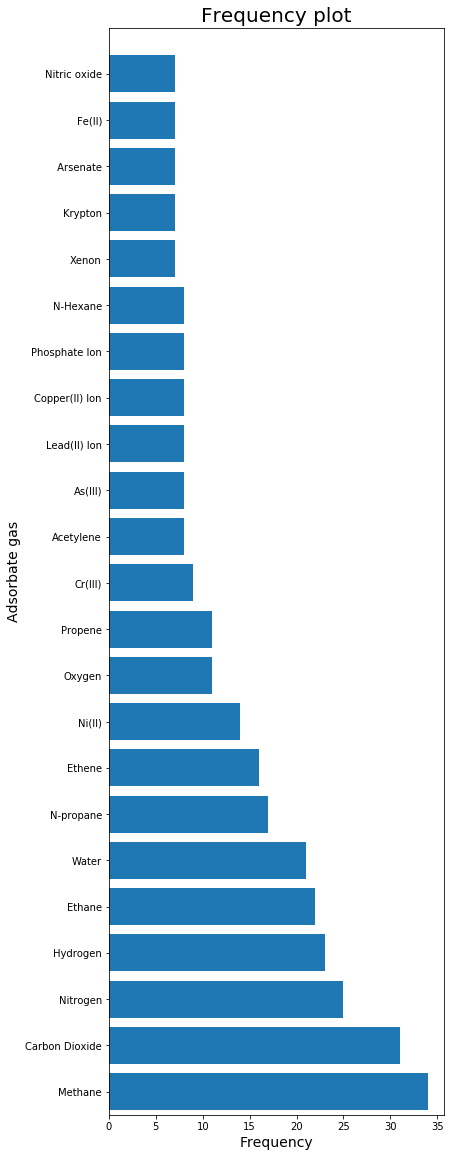

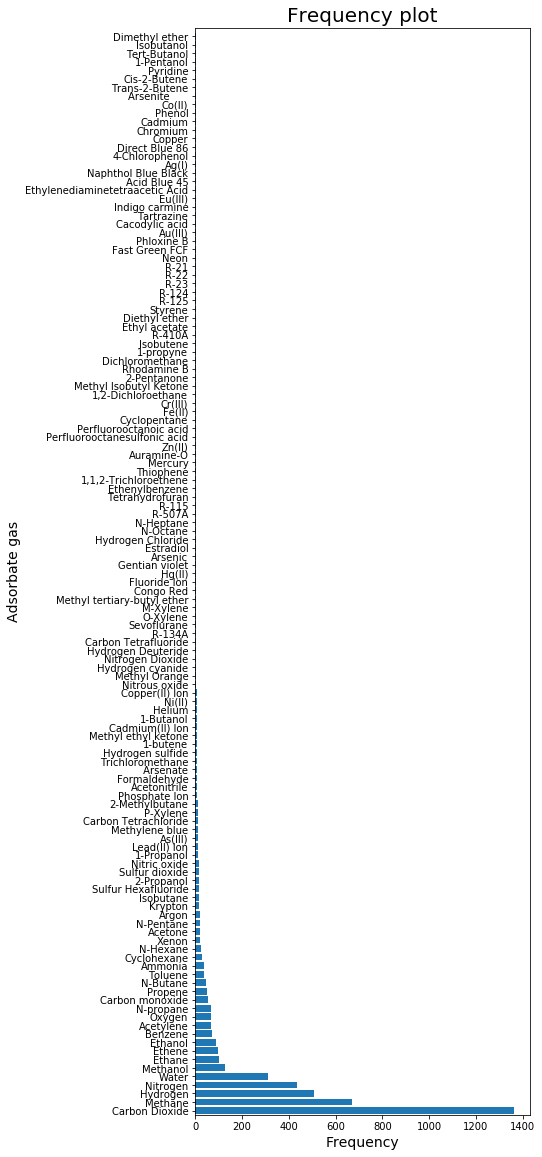

In [39]:
def plot_frequency_of_gases(min_data_points_for_pruning):
    
    gas_sum = np.sum(material_gas_matrix, axis=0)
    old_order = np.arange(len(gas_sum))
    new_order = sorted(old_order, key=lambda x: gas_sum[x], reverse=True)
    
    sums = np.sum(material_gas_matrix, axis=0)

    most_common_gases = np.full(len(sums), "", dtype='object')
    for (i, o) in enumerate(new_order):
        most_common_gases[i] = (key_to_gas[column_to_gas_temp[o].split('_')[0]])

    keep_row, keep_column = prune_matrix(min_data_points_for_pruning, False)
    
    sparsed_sum = np.sum(material_gas_matrix[keep_row, :][:, keep_column], axis=0)
    sparsed_old_order = np.arange(len(sparsed_sum))
    sparsed_new_order = sorted(sparsed_old_order, key=lambda x: sparsed_sum[x], reverse=True)
    

    most_common_sparsed_gases = np.full(np.sum(np.greater(sparsed_sum, 0)), "", dtype='object')
    for (i, o) in enumerate(sparsed_new_order):
        most_common_sparsed_gases[i] = (key_to_gas[column_to_gas_temp[o].split('_')[0]])
    
    fig = plt.figure(figsize=(6,20))
    ax = plt.gca()
    ax.barh(most_common_sparsed_gases, sparsed_sum[sparsed_new_order][np.greater(sparsed_sum, 0)])
    ax.set_xlabel('Frequency', fontsize=14)
    ax.set_ylabel('Adsorbate gas', fontsize=14)
    ax.set_title('Frequency plot', fontsize=20)
    ax.set_ylim([-0.5, len(most_common_sparsed_gases)])
    
    fig.subplots_adjust(wspace=0.5)
    plt.show()
plot_frequency_of_gases(MIN_UNIQUE_ISOTHERMS)
plot_frequency_of_gases(0)

## Minimum data point requirement vs sparsity of matrix graph

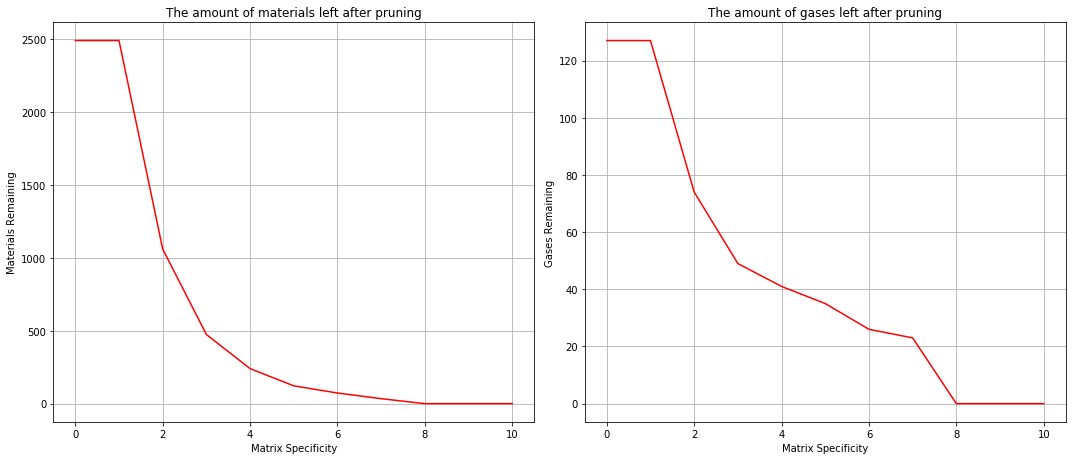

In [40]:
point_requirement_matrix = np.copy(material_gas_matrix)
matrix_sum = np.sum(point_requirement_matrix)
count = 0
cut_materials = []
cut_gases = []

for n in range(11):
    while True:
        
        materials_cut = 0
        gases_cut = 0
        
        for row in range(len(material_to_row)):
            if np.sum(point_requirement_matrix[row,:]) < n:
                point_requirement_matrix[row,:] = False
        
        for column in range(len(gas_temp_to_column)):
            if np.sum(point_requirement_matrix[:,column]) < n:
                point_requirement_matrix[:,column] = False
    
        if matrix_sum == np.sum(point_requirement_matrix):
            break
        
        matrix_sum = np.sum(point_requirement_matrix)
        count += 1
    
    for row in range(len(material_to_row)):
        if point_requirement_matrix.sum(axis = 1)[row] == 0:
            materials_cut += 1
    
    for column in range(len(gas_temp_to_column)):
        if point_requirement_matrix.sum(axis = 0)[column] == 0:
            gases_cut += 1
            
    cut_materials.append(len(material_to_row) - materials_cut)
    cut_gases.append(len(gas_temp_to_column) - gases_cut)   

#Plots how the the gases and the mofs act with an increase in matrix specificity
n = range(11)
plt.figure(figsize = (15,6.5))

plt.subplot(121)
plt.plot(n, cut_materials, 'r')
plt.title('The amount of materials left after pruning')
plt.ylabel('Materials Remaining')
plt.xlabel('Matrix Specificity')
plt.grid()
plt.tight_layout()

plt.subplot(122)
plt.plot(n,cut_gases,'r')
plt.title('The amount of gases left after pruning')
plt.ylabel('Gases Remaining')
plt.xlabel('Matrix Specificity')
plt.grid()
plt.tight_layout()

plt.show()
#TODO plot the graphs as points

### Grabs individual isotherms for further analysis

In [41]:
for isotherm in experimental_isotherms:
    filename = isotherm['filename']
    if os.path.isfile('isotherms/' + filename + '.json'):
        #print(filename + '.json already exists')
        continue
    url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
    isotherm_data = json.loads(requests.get(url).content)
    with open('isotherms/' + filename + '.json', 'w') as outfile:
        json.dump(isotherm_data, outfile)

# Write Data Matrix to a Pandas DataFrame and write it to a file

In [42]:
material_gas_dataframe = pd.DataFrame(data=np.array(material_gas_matrix[:, keep_column][keep_row, :]),
                                 columns=[column_to_gas_temp[i] for i in np.arange(material_gas_matrix.shape[1])[keep_column]],
                                 index=[row_to_material[i] for i in np.arange(material_gas_matrix.shape[0])[keep_row]],
                                dtype=int)

material_gas_dataframe.to_csv('data/sparsity_matrix_' + str(MIN_UNIQUE_ISOTHERMS) + '_min_unique_isotherms.csv')
material_gas_dataframe[material_gas_dataframe.columns[0:5]][0:5]

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1,1,1,0,1
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,1,1,1,1,1
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,1,1,1,1,0
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1,1,1,1,1
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,1,0,1,0,0
